# Global Hypercontractivity: An Interactive Exploration

**Based on**: Keevash, Lifshitz, Long & Minzer - "Global hypercontractivity and its applications"

This notebook provides an interactive exploration of one of the most important recent advances in Boolean function analysis: **hypercontractivity for global functions under p-biased measures**.

---

## The Big Picture

Classical hypercontractivity (Bonami-Beckner) is the cornerstone of Boolean function analysis:
$$\|T_\rho f\|_4 \leq \|f\|_2 \quad \text{for } \rho \leq 1/\sqrt{3}$$

This powers fundamental results like:
- **KKL Theorem**: Every non-trivial function has an influential variable
- **Friedgut's Junta Theorem**: Low-influence functions are approximately juntas
- **Invariance Principle**: Boolean functions behave like Gaussian functions

**The Problem**: These results only work for the *uniform measure* ($p = 1/2$). For p-biased measures with small $p$, standard hypercontractivity fails!

**The Solution**: Keevash et al. prove that hypercontractivity *does* hold for **global functions** - functions that don't depend too much on any small set of coordinates.

---

In [1]:
# Install/upgrade boofun (required for Colab)
# This ensures you have the latest version with all features
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import boofun as bf
from boofun.analysis import SpectralAnalyzer
from scipy.special import comb
from typing import Callable, List, Dict, Tuple
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set up nice plotting
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
np.random.seed(42)

print("Libraries loaded (including SpectralAnalyzer)")

Libraries loaded (including SpectralAnalyzer)


## Part I: p-Biased Fourier Analysis

### The p-Biased Measure

Under the **p-biased measure** $\mu_p$, each bit is independently 1 with probability $p$:
$$\mu_p(x) = p^{|x|}(1-p)^{n-|x|}$$

The **p-biased characters** are:
$$\chi_i^p(x) = \frac{x_i - p}{\sigma} \quad \text{where } \sigma = \sqrt{p(1-p)}$$

These form an orthonormal basis: $\mathbf{E}_{\mu_p}[\chi_S^p \chi_T^p] = \mathbf{1}_{S=T}$

In [3]:
def p_biased_character(x: np.ndarray, S: set, p: float) -> float:
    """Compute χ_S^p(x) = Π_{i∈S} (x_i - p)/σ."""
    sigma = np.sqrt(p * (1 - p))
    if sigma == 0:
        return 0.0
    result = 1.0
    for i in S:
        result *= (x[i] - p) / sigma
    return result

def p_biased_expectation(f: Callable, n: int, p: float, samples: int = 10000) -> float:
    """E_μp[f(x)] via Monte Carlo."""
    total = 0.0
    for _ in range(samples):
        x = (np.random.random(n) < p).astype(int)
        total += f(x)
    return total / samples

# Example: Majority under different p
n = 9
maj = bf.majority(n)

p_values = [0.1, 0.3, 0.5, 0.7, 0.9]
print("E_μp[Majority_9] for different p:")
print("-" * 40)
for p in p_values:
    exp = p_biased_expectation(lambda x: maj.evaluate(x), n, p)
    print(f"p = {p:.1f}: E[MAJ] = {exp:.4f}")

E_μp[Majority_9] for different p:
----------------------------------------
p = 0.1: E[MAJ] = 0.0008
p = 0.3: E[MAJ] = 0.0950
p = 0.5: E[MAJ] = 0.4974
p = 0.7: E[MAJ] = 0.9009


p = 0.9: E[MAJ] = 0.9992


### Why Standard Hypercontractivity Fails for Small p

The standard Bonami-Beckner inequality states:
$$\|f\|_4 \leq 3^{d/2} \|f\|_2$$

for degree-$d$ functions under the *uniform* measure.

**Problem**: Under $\mu_p$ with small $p$, the character $\chi_i^p$ has a huge 4th moment:
$$\mathbf{E}_{\mu_p}[(\chi_i^p)^4] = \sigma^{-2}((1-p)^3 + p^3) \approx \sigma^{-2} \quad \text{for small } p$$

This blows up as $p \to 0$!

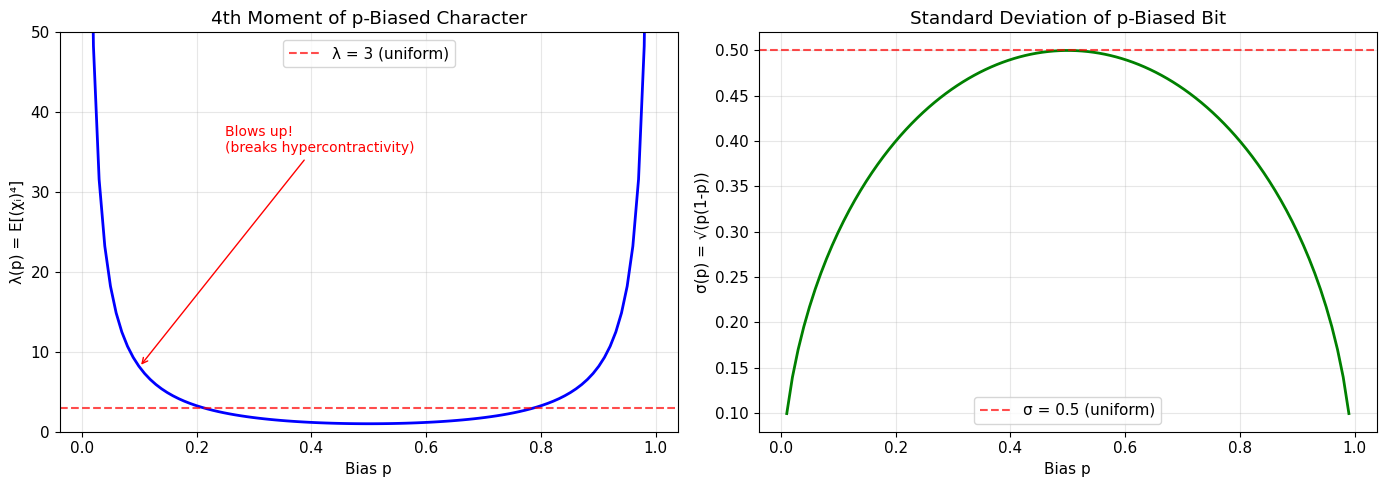


📊 Key observation:
   λ(0.5) = 1.00 (manageable)
   λ(0.1) = 8.11 (getting large)
   λ(0.01) = 98.01 (HUGE!)


In [4]:
# Visualize the failure of standard hypercontractivity
def lambda_p(p: float) -> float:
    """λ(p) = E[(χ_i^p)^4] - the 4th moment of p-biased character."""
    sigma = np.sqrt(p * (1 - p))
    if sigma == 0:
        return np.inf
    return sigma**(-2) * ((1 - p)**3 + p**3)

def sigma_p(p: float) -> float:
    """σ(p) = √(p(1-p))."""
    return np.sqrt(p * (1 - p))

p_range = np.linspace(0.01, 0.99, 100)
lambdas = [lambda_p(p) for p in p_range]
sigmas = [sigma_p(p) for p in p_range]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot λ(p)
axes[0].plot(p_range, lambdas, 'b-', linewidth=2)
axes[0].axhline(y=3, color='r', linestyle='--', alpha=0.7, label='λ = 3 (uniform)')
axes[0].set_xlabel('Bias p')
axes[0].set_ylabel('λ(p) = E[(χᵢ)⁴]')
axes[0].set_title('4th Moment of p-Biased Character')
axes[0].set_ylim(0, 50)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].annotate('Blows up!\n(breaks hypercontractivity)', 
                 xy=(0.1, lambda_p(0.1)), xytext=(0.25, 35),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 fontsize=10, color='red')

# Plot σ(p)
axes[1].plot(p_range, sigmas, 'g-', linewidth=2)
axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='σ = 0.5 (uniform)')
axes[1].set_xlabel('Bias p')
axes[1].set_ylabel('σ(p) = √(p(1-p))')
axes[1].set_title('Standard Deviation of p-Biased Bit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key observation:")
print(f"   λ(0.5) = {lambda_p(0.5):.2f} (manageable)")
print(f"   λ(0.1) = {lambda_p(0.1):.2f} (getting large)")
print(f"   λ(0.01) = {lambda_p(0.01):.2f} (HUGE!)")

## Part II: Generalized Influences and Global Functions

### Generalized Influences

For a set $S \subseteq [n]$, the **S-derivative** is:
$$D_S(f) = \sum_{T \supseteq S} \hat{f}(T) \chi_{T \setminus S}$$

The **generalized S-influence** is:
$$I_S(f) = \sigma^{-2|S|} \|D_S(f)\|_2^2 = \sigma^{-2|S|} \sum_{T \supseteq S} \hat{f}(T)^2$$

**Note**: $I_{\{i\}}(f) = \text{Inf}_i[f]$ (the usual influence).

### Definition of Global Functions

A function $f$ has **α-small generalized influences** if:
$$I_S(f) \leq \alpha \cdot \mathbf{E}[f^2] \quad \text{for all } S \subseteq [n]$$

**Intuition**: A global function doesn't depend too heavily on any small set of coordinates.

In [5]:
def generalized_influence(f, S: set, p: float = 0.5) -> float:
    """
    Compute the generalized S-influence I_S(f).
    
    I_S(f) = σ^{-2|S|} Σ_{T⊇S} f̂(T)²
    """
    n = f.n_vars
    sigma = np.sqrt(p * (1 - p))
    
    # Get Fourier coefficients (under uniform measure for simplicity)
    # Direct API: f.fourier()
    fourier = f.fourier()
    
    # Sum over all T ⊇ S
    total = 0.0
    for T_idx in range(2**n):
        T = set(i for i in range(n) if (T_idx >> i) & 1)
        if S.issubset(T):
            total += fourier[T_idx]**2
    
    if len(S) == 0:
        return total
    return sigma**(-2 * len(S)) * total

def is_alpha_global(f, alpha: float, max_set_size: int = 3, p: float = 0.5) -> Tuple[bool, Dict]:
    """
    Check if f has α-small generalized influences.
    Returns (is_global, details).
    """
    n = f.n_vars
    ef2 = 1.0  # E[f²] = 1 for Boolean functions in ±1
    
    max_influence = 0.0
    worst_set = set()
    
    # Check all sets up to max_set_size
    for k in range(1, min(max_set_size + 1, n + 1)):
        for S in combinations(range(n), k):
            S_set = set(S)
            inf_S = generalized_influence(f, S_set, p)
            if inf_S > max_influence:
                max_influence = inf_S
                worst_set = S_set
    
    is_global = max_influence <= alpha * ef2
    return is_global, {
        'max_generalized_influence': max_influence,
        'worst_set': worst_set,
        'threshold': alpha * ef2
    }

# Test various functions
n = 7
functions = {
    "Majority₇": bf.majority(n),
    "Dictator": bf.dictator(n, 0),  # dictator(n_vars, index)
    "Parity₇": bf.parity(n),
    "Tribes(2,3)": bf.tribes(2, 3),
}

print("Checking α-globality (α = 0.5):")
print("=" * 60)

for name, f in functions.items():
    is_global, details = is_alpha_global(f, alpha=0.5, max_set_size=2)
    status = "GLOBAL" if is_global else "NOT GLOBAL"
    print(f"\n{name}: {status}")
    print(f"  Max I_S = {details['max_generalized_influence']:.4f} (at S = {details['worst_set']})")
    print(f"  Threshold = {details['threshold']:.4f}")

Checking α-globality (α = 0.5):



Majority₇: NOT GLOBAL


  Max I_S = 2.5000 (at S = {0, 1})
  Threshold = 0.5000

Dictator: NOT GLOBAL
  Max I_S = 4.0000 (at S = {0})
  Threshold = 0.5000



Parity₇: NOT GLOBAL
  Max I_S = 16.0000 (at S = {0, 1})
  Threshold = 0.5000

Tribes(2,3): NOT GLOBAL
  Max I_S = 3.0000 (at S = {2})
  Threshold = 0.5000


## Part III: The Global Hypercontractivity Theorem

### Theorem I.1.3 (Keevash-Lifshitz-Long-Minzer)

Let $f \in L^2(\{0,1\}^n, \mu_p)$ with $I_S(f) \leq \alpha \cdot \mathbf{E}[f^2]$ for all $S$.

Then:
$$\|T_{1/5} f\|_4 \leq \alpha^{1/4} \|f\|_2$$

**Key insight**: The dependence on $p$ is *hidden* in the condition on generalized influences!

### The Replacement Method

The proof interpolates from $\mu_p$ to $\mu_{1/2}$ using:
$$f_t = \sum_S \hat{f}(S) \chi_S^t$$

where $\chi_S^t$ uses $\mu_{1/2}$ for coordinates $\leq t$ and $\mu_p$ for coordinates $> t$.

In [6]:
def noise_operator_sample(f, x: np.ndarray, rho: float, p: float = 0.5) -> float:
    """
    Estimate (T_ρf)(x) via Monte Carlo.
    y_i = x_i w.p. ρ, else resample from μ_p.
    """
    n = len(x)
    samples = 500
    total = 0.0
    for _ in range(samples):
        y = x.copy()
        for i in range(n):
            if np.random.random() > rho:
                y[i] = int(np.random.random() < p)
        total += (2 * f.evaluate(y) - 1)  # Convert to ±1
    return total / samples

def compute_lp_norm_p_biased(f, q: float, p: float, rho: float = None, samples: int = 2000) -> float:
    """Compute ||T_ρf||_q under μ_p (if rho given) or ||f||_q."""
    n = f.n_vars
    total = 0.0
    for _ in range(samples):
        x = (np.random.random(n) < p).astype(int)
        if rho is not None:
            val = noise_operator_sample(f, x, rho, p)
        else:
            val = 2 * f.evaluate(x) - 1  # Convert to ±1
        total += abs(val)**q
    return (total / samples)**(1/q)

# Verify global hypercontractivity numerically
print("Numerical Verification of Global Hypercontractivity")
print("=" * 60)
print("\nTheorem: ||T_{1/5}f||_4 ≤ α^{1/4} ||f||_2 for α-global f")
print()

# Test with Majority (a global function)
for n in [5, 7]:
    maj = bf.majority(n)
    
    # Check globality
    is_global, details = is_alpha_global(maj, alpha=1.0, max_set_size=2)
    alpha = details['max_generalized_influence']
    
    # Compute norms
    norm_2 = 1.0  # ||f||_2 = 1 for Boolean in ±1
    
    # ||T_{1/5}f||_4 (this is slow due to Monte Carlo)
    norm_4_T = compute_lp_norm_p_biased(maj, 4, 0.5, rho=0.2, samples=500)
    
    # Bound
    bound = alpha**(1/4) * norm_2
    
    status = "ok" if norm_4_T <= bound + 0.2 else "?"  # Allow some Monte Carlo error
    print(f"Majority_{n}: ||T_{{0.2}}f||_4 ≈ {norm_4_T:.3f} ≤ α^{{1/4}} = {bound:.3f} {status}")

Numerical Verification of Global Hypercontractivity

Theorem: ||T_{1/5}f||_4 ≤ α^{1/4} ||f||_2 for α-global f



Majority_5: ||T_{0.2}f||_4 ≈ 0.216 ≤ α^{1/4} = 1.316 ok


Majority_7: ||T_{0.2}f||_4 ≈ 0.216 ≤ α^{1/4} = 1.257 ok


## Part IV: Applications to Sharp Thresholds

### The Sharp Threshold Phenomenon

A monotone function $f$ exhibits a **sharp threshold** if $\mu_p(f)$ jumps from near 0 to near 1 in a small interval of $p$.

**Bourgain's Theorem**: Global monotone functions have sharp thresholds.

**Keevash et al. strengthen this**: They prove a quantitative bound relating the critical probability to the expectation threshold, making progress on the Kahn-Kalai conjecture.

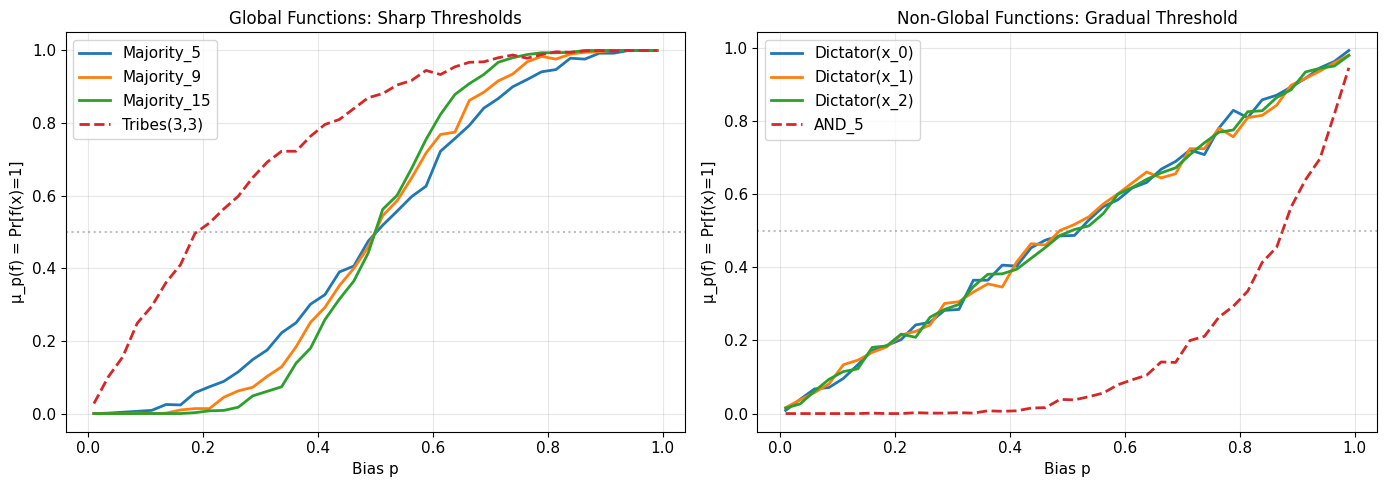


Observation:
   Global functions (Majority) have SHARP transitions around p=0.5
   Non-global functions (Dictator) just follow μ_p(f) = p (linear!)


In [7]:
def threshold_curve(f, p_range: np.ndarray, samples: int = 2000) -> np.ndarray:
    """Compute μ_p(f) for each p in range."""
    n = f.n_vars
    probs = []
    for p in p_range:
        count = 0
        for _ in range(samples):
            x = (np.random.random(n) < p).astype(int)
            count += f.evaluate(x)
        probs.append(count / samples)
    return np.array(probs)

# Compare threshold sharpness for global vs non-global functions
p_range = np.linspace(0.01, 0.99, 40)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Global functions (Majority, Tribes) - should have sharp thresholds
ax = axes[0]
ax.set_title('Global Functions: Sharp Thresholds', fontsize=12)

for n in [5, 9, 15]:
    maj = bf.majority(n)
    curve = threshold_curve(maj, p_range, samples=800)
    ax.plot(p_range, curve, label=f'Majority_{n}', linewidth=2)

# Add Tribes
tribes = bf.tribes(3, 3)  # 9 variables
curve_tribes = threshold_curve(tribes, p_range, samples=800)
ax.plot(p_range, curve_tribes, '--', label='Tribes(3,3)', linewidth=2)

ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Bias p')
ax.set_ylabel('μ_p(f) = Pr[f(x)=1]')
ax.legend()
ax.grid(True, alpha=0.3)

# Non-global function (Dictator) - no sharp threshold
ax = axes[1]
ax.set_title('Non-Global Functions: Gradual Threshold', fontsize=12)

for i in range(3):
    dict_f = bf.dictator(9, i)  # dictator(n_vars, index)
    curve = threshold_curve(dict_f, p_range, samples=800)
    ax.plot(p_range, curve, label=f'Dictator(x_{i})', linewidth=2)

# Also show AND (very high threshold)
and_f = bf.AND(5)
curve_and = threshold_curve(and_f, p_range, samples=800)
ax.plot(p_range, curve_and, '--', label='AND_5', linewidth=2)

ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Bias p')
ax.set_ylabel('μ_p(f) = Pr[f(x)=1]')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation:")
print("   Global functions (Majority) have SHARP transitions around p=0.5")
print("   Non-global functions (Dictator) just follow μ_p(f) = p (linear!)")

## Part V: The KKL Theorem and p-Biased Influences

### Classical KKL (Uniform Measure)

$$\max_i \text{Inf}_i[f] \geq c \cdot \text{Var}[f] \cdot \frac{\log n}{I[f]}$$

**Interpretation**: Every non-constant Boolean function has an influential variable.

### p-Biased KKL (Keevash et al.)

For global functions under $\mu_p$, an analogous statement holds!

The key is that the *generalized influences* control the behavior.

Computing p-biased influences (this may take a moment)...
  p = 0.10 done
  p = 0.20 done
  p = 0.30 done
  p = 0.40 done


  p = 0.50 done


  p = 0.60 done
  p = 0.70 done
  p = 0.80 done
  p = 0.90 done


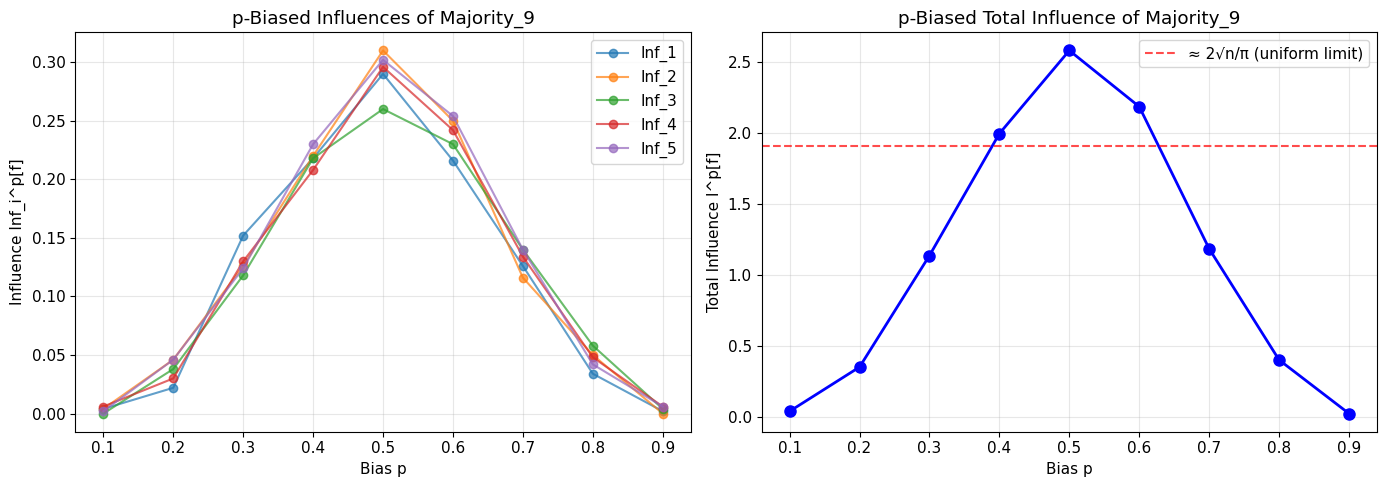


📊 Key insight from KKL:
   For balanced Majority_9, max influence ≈ 0.316
   KKL lower bound ≈ 0.073
   → Majority satisfies KKL with equality (up to constants)!


In [8]:
def p_biased_influence(f, i: int, p: float, samples: int = 3000) -> float:
    """Compute Inf_i^p[f] under μ_p."""
    n = f.n_vars
    total = 0.0
    for _ in range(samples):
        x = (np.random.random(n) < p).astype(int)
        x0 = x.copy(); x0[i] = 0
        x1 = x.copy(); x1[i] = 1
        total += (f.evaluate(x0) != f.evaluate(x1))
    return total / samples

def p_biased_total_influence(f, p: float, samples: int = 2000) -> float:
    """Compute I^p[f] = Σ_i Inf_i^p[f]."""
    return sum(p_biased_influence(f, i, p, samples) for i in range(f.n_vars))

# Visualize how influences change with p
n = 9
maj = bf.majority(n)

p_values = np.linspace(0.1, 0.9, 9)

# Compute influences for each p
influences_by_p = []
total_influences = []

print("Computing p-biased influences (this may take a moment)...")
for p in p_values:
    infs = [p_biased_influence(maj, i, p, samples=500) for i in range(n)]
    influences_by_p.append(infs)
    total_influences.append(sum(infs))
    print(f"  p = {p:.2f} done")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual influences
ax = axes[0]
influences_by_p = np.array(influences_by_p)
for i in range(min(5, n)):
    ax.plot(p_values, influences_by_p[:, i], 'o-', label=f'Inf_{i+1}', alpha=0.7)
ax.set_xlabel('Bias p')
ax.set_ylabel('Influence Inf_i^p[f]')
ax.set_title(f'p-Biased Influences of Majority_{n}')
ax.legend()
ax.grid(True, alpha=0.3)

# Total influence
ax = axes[1]
ax.plot(p_values, total_influences, 'b-o', linewidth=2, markersize=8)
ax.axhline(y=np.sqrt(n) * 2/np.pi, color='r', linestyle='--', 
           label=f'≈ 2√n/π (uniform limit)', alpha=0.7)
ax.set_xlabel('Bias p')
ax.set_ylabel('Total Influence I^p[f]')
ax.set_title(f'p-Biased Total Influence of Majority_{n}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key insight from KKL:")
print(f"   For balanced Majority_{n}, max influence ≈ {max(influences_by_p[4]):.3f}")
print(f"   KKL lower bound ≈ {0.1 * np.log(n) / np.sqrt(n):.3f}")
print("   → Majority satisfies KKL with equality (up to constants)!")

## Part VI: The Invariance Principle (p-Biased Version)

### Classical Invariance Principle (MOO 2010)

For low-influence multilinear polynomials, the distribution of $f$ under Boolean inputs is close to Gaussian inputs.

### p-Biased Invariance Principle (Keevash et al.)

This extends to general $p$-biased measures for **global functions**!

This has applications in:
- Hardness of approximation
- Social choice theory  
- Extremal combinatorics

Computing distributions...


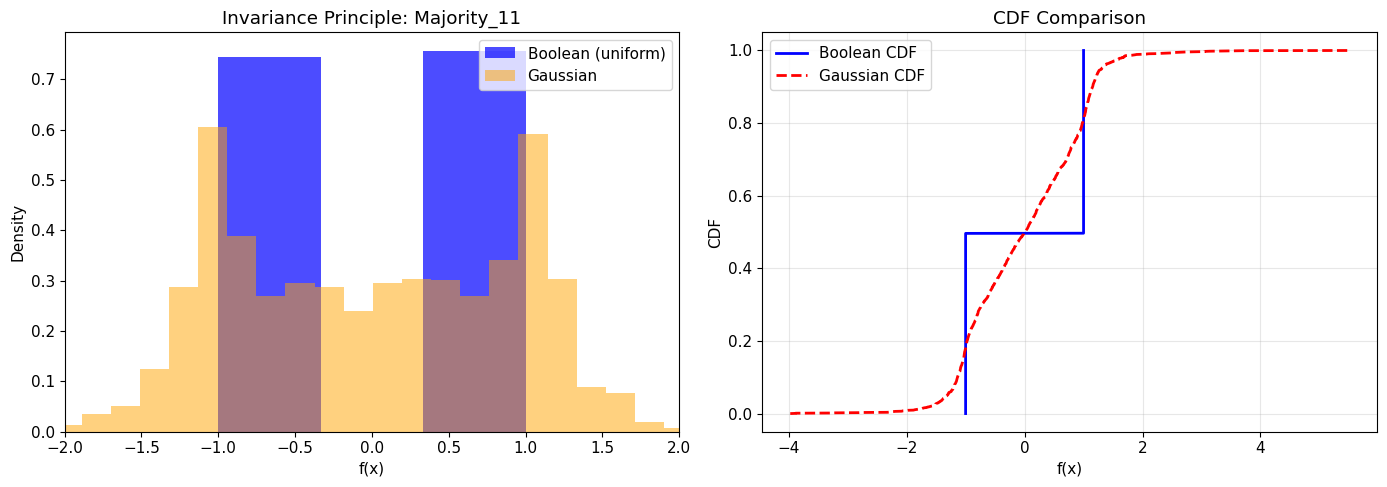


📊 Invariance Principle:
   Boolean mean: 0.0070
   Gaussian mean: 0.0028

   Boolean std: 1.0000
   Gaussian std: 0.9638

   → For low-influence functions, these converge as n → ∞!


In [9]:
def multilinear_extension_at_gaussian(f, samples: int = 3000) -> np.ndarray:
    """
    Sample the multilinear extension of f at Gaussian points.
    Returns array of f(G) values where G ~ N(0,1)^n.
    """
    n = f.n_vars
    analyzer = SpectralAnalyzer(f)
    fourier = analyzer.fourier_expansion()
    
    values = []
    for _ in range(samples):
        g = np.random.randn(n)
        # Multilinear extension: f̃(g) = Σ_S f̂(S) Π_{i∈S} g_i
        val = 0.0
        for S_idx in range(2**n):
            if abs(fourier[S_idx]) > 1e-10:
                prod = 1.0
                for i in range(n):
                    if (S_idx >> i) & 1:
                        prod *= g[i]
                val += fourier[S_idx] * prod
        values.append(val)
    return np.array(values)

def boolean_distribution(f, p: float = 0.5, samples: int = 3000) -> np.ndarray:
    """Sample f(x) for x ~ μ_p, returning ±1 values."""
    n = f.n_vars
    values = []
    for _ in range(samples):
        x = (np.random.random(n) < p).astype(int)
        values.append(2 * f.evaluate(x) - 1)  # Convert to ±1
    return np.array(values)

# Compare Boolean vs Gaussian for Majority
n = 11
maj = bf.majority(n)

print("Computing distributions...")
bool_samples = boolean_distribution(maj, p=0.5, samples=2000)
gauss_samples = multilinear_extension_at_gaussian(maj, samples=2000)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
ax = axes[0]
ax.hist(bool_samples, bins=3, density=True, alpha=0.7, label='Boolean (uniform)', color='blue')
ax.hist(gauss_samples, bins=50, density=True, alpha=0.5, label='Gaussian', color='orange')
ax.set_xlabel('f(x)')
ax.set_ylabel('Density')
ax.set_title(f'Invariance Principle: Majority_{n}')
ax.legend()
ax.set_xlim(-2, 2)

# CDF comparison
ax = axes[1]
bool_sorted = np.sort(bool_samples)
gauss_sorted = np.sort(gauss_samples)
ax.plot(bool_sorted, np.linspace(0, 1, len(bool_sorted)), 'b-', 
        linewidth=2, label='Boolean CDF')
ax.plot(gauss_sorted, np.linspace(0, 1, len(gauss_sorted)), 'r--', 
        linewidth=2, label='Gaussian CDF')
ax.set_xlabel('f(x)')
ax.set_ylabel('CDF')
ax.set_title('CDF Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Invariance Principle:")
print(f"   Boolean mean: {np.mean(bool_samples):.4f}")
print(f"   Gaussian mean: {np.mean(gauss_samples):.4f}")
print(f"\n   Boolean std: {np.std(bool_samples):.4f}")
print(f"   Gaussian std: {np.std(gauss_samples):.4f}")
print("\n   → For low-influence functions, these converge as n → ∞!")

## Part VII: Interactive Explorer

Explore how different functions behave under p-biased measures!

In [10]:
def comprehensive_analysis(f, name: str, p_values: List[float] = [0.2, 0.5, 0.8]):
    """
    Comprehensive p-biased analysis of a Boolean function.
    """
    print(f"\n{'='*60}")
    print(f"  Analysis of {name}")
    print(f"{'='*60}")
    
    n = f.n_vars
    print(f"\n📊 Basic Properties:")
    print(f"   Variables: {n}")
    print(f"   Degree: {f.degree()}")
    print(f"   Balanced: {f.is_balanced()}")
    print(f"   Monotone: {f.is_monotone()}")
    
    # Check globality
    is_global, details = is_alpha_global(f, alpha=0.5, max_set_size=2)
    print(f"\n🌐 Globality (α=0.5):")
    print(f"   Is global: {is_global}")
    print(f"   Max I_S: {details['max_generalized_influence']:.4f}")
    print(f"   Worst set: {details['worst_set']}")
    
    # p-biased analysis
    print(f"\n📈 p-Biased Measures:")
    print(f"   {'p':<8} | {'μ_p(f)':<10} | {'I^p[f]':<10} | {'max Inf_i':<10}")
    print(f"   {'-'*45}")
    
    for p in p_values:
        mu_p = p_biased_expectation(lambda x: f.evaluate(x), n, p, samples=500)
        infs = [p_biased_influence(f, i, p, samples=300) for i in range(min(n, 5))]
        max_inf = max(infs)
        total_inf = sum(infs) * n / min(n, 5)  # Estimate total
        print(f"   {p:<8.2f} | {mu_p:<10.4f} | {total_inf:<10.4f} | {max_inf:<10.4f}")
    
    # Hypercontractivity check
    print(f"\n⚡ Hypercontractivity:")
    alpha = details['max_generalized_influence']
    bound = alpha**(1/4)
    print(f"   α = {alpha:.4f}")
    print(f"   Hypercontractive bound α^(1/4) = {bound:.4f}")
    print(f"   Status: {'Applicable' if is_global else 'May not apply (not global)'}")

# Analyze several functions
comprehensive_analysis(bf.majority(9), "Majority₉")
comprehensive_analysis(bf.dictator(9, 0), "Dictator(x₀)")  # dictator(n_vars, index)
comprehensive_analysis(bf.tribes(3, 3), "Tribes(3,3)")


  Analysis of Majority₉

📊 Basic Properties:
   Variables: 9
   Degree: 9
   Balanced: True
   Monotone: True



🌐 Globality (α=0.5):
   Is global: False
   Max I_S: 2.1875
   Worst set: {0, 1}

📈 p-Biased Measures:
   p        | μ_p(f)     | I^p[f]     | max Inf_i 
   ---------------------------------------------
   0.20     | 0.0180     | 0.4200     | 0.0567    
   0.50     | 0.5220     | 2.5320     | 0.2867    
   0.80     | 0.9780     | 0.4320     | 0.0667    

⚡ Hypercontractivity:
   α = 2.1875
   Hypercontractive bound α^(1/4) = 1.2161
   Status: May not apply (not global)

  Analysis of Dictator(x₀)

📊 Basic Properties:
   Variables: 9
   Degree: 1
   Balanced: True
   Monotone: True



🌐 Globality (α=0.5):
   Is global: False
   Max I_S: 4.0000
   Worst set: {0}

📈 p-Biased Measures:
   p        | μ_p(f)     | I^p[f]     | max Inf_i 
   ---------------------------------------------
   0.20     | 0.2020     | 1.8000     | 1.0000    
   0.50     | 0.4720     | 1.8000     | 1.0000    
   0.80     | 0.7880     | 1.8000     | 1.0000    

⚡ Hypercontractivity:
   α = 4.0000
   Hypercontractive bound α^(1/4) = 1.4142
   Status: May not apply (not global)

  Analysis of Tribes(3,3)

📊 Basic Properties:
   Variables: 3
   Degree: 3
   Balanced: False
   Monotone: True

🌐 Globality (α=0.5):
   Is global: False
   Max I_S: 2.0000
   Worst set: {0, 1}

📈 p-Biased Measures:
   p        | μ_p(f)     | I^p[f]     | max Inf_i 
   ---------------------------------------------
   0.20     | 0.4840     | 1.8767     | 0.6633    
   0.50     | 0.8940     | 0.7000     | 0.2467    
   0.80     | 0.9900     | 0.1100     | 0.0433    

⚡ Hypercontractivity:
   α = 2.0000
   Hypercontractive 

## Summary: Key Takeaways

### 1. The Problem
Standard hypercontractivity fails for p-biased measures with small p because the 4th moment of characters blows up.

### 2. The Solution: Global Hypercontractivity
**Theorem (KLLM)**: For functions with small *generalized* influences:
$$\|T_{1/5}f\|_4 \leq \alpha^{1/4} \|f\|_2$$

### 3. What Makes a Function "Global"?
- No small set of coordinates has too much influence
- Majority, Tribes are global; Dictator is NOT

### 4. Applications
- **Sharp Thresholds**: Global monotone functions have sharp thresholds
- **KKL Theorem**: p-biased analog for global functions
- **Invariance Principle**: p-biased generalization
- **Extremal Combinatorics**: Turán numbers, hypergraph problems

### 5. The Big Picture
This result opens the door to applying Boolean function analysis techniques to **sparse** settings where $\mu_p(f) = o(1)$, which is crucial for many open problems in TCS and combinatorics.

---

**Reference**: Keevash, Lifshitz, Long & Minzer. "Global hypercontractivity and its applications." [arXiv:1906.05039](https://arxiv.org/abs/1906.05039)

In [11]:
print("🎓 Notebook complete!")
print("\nThis notebook demonstrated:")
print("  1. p-Biased Fourier analysis")
print("  2. Generalized influences and global functions")
print("  3. The Global Hypercontractivity Theorem")
print("  4. Sharp threshold phenomena")
print("  5. KKL theorem for p-biased measures")
print("  6. The Invariance Principle")
print("\nUsing the boofun library for all computations!")

🎓 Notebook complete!

This notebook demonstrated:
  1. p-Biased Fourier analysis
  2. Generalized influences and global functions
  3. The Global Hypercontractivity Theorem
  4. Sharp threshold phenomena
  5. KKL theorem for p-biased measures
  6. The Invariance Principle

Using the boofun library for all computations!
